# Analyze pendulum data
Use this notebook to quickly test whether your pendulum data makes sense!

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

sys.path.append('../../External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure

In [2]:
# Example file location
filename_example = 'data_pendulum_example/timer_output.dat'

## Data reader

In [3]:
# Read in data
def read_data(filename):
    dat = np.genfromtxt(filename, delimiter='\t', names=('n', 't_s'))
    return dat

## Read and plot the data

In [4]:
data_example = read_data(filename_example)
n, t = data_example['n'][2:], data_example['t_s'][2:]

#fit function
def lin_funk(x,T,b):
    return T*x+b

#fit data with Minuit
chi2 = Chi2Regression(lin_funk, n, t)

minuit = Minuit(chi2, T=3, b=0)
minuit.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.1594                     │              Nfcn = 34               │
│ EDM = 7.25e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ T    │   2.734   │   0.006   │            │            │         │         │       │
│ 1 │ b    │   -4.36   │   0.26    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        T        b │
├───┼───────────────────┤
│ T │ 3.99e-05 -0.00144 │
│ b │ -0.00144   0.0666 │
└───┴───────────────────┘

In [5]:
T_fit , b_fit = minuit.values

2.7335449078139993


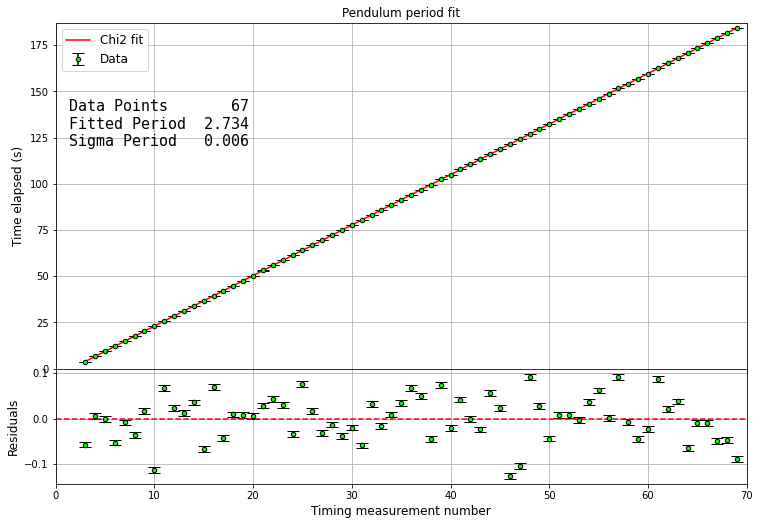

In [6]:
print(T_fit)
# Plotting
sig_t = minuit.errors[0]     # Set your own values...
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), gridspec_kw={'height_ratios':[4,1]}, sharex=True)

ax[0].set_title('Pendulum period fit')
ax[0].errorbar(n, t, yerr=sig_t, color='lime', fmt='.',markersize =9, label='Data', capsize=6, ecolor='k',markeredgecolor='k')
ax[0].plot(n, lin_funk(n, T_fit, b_fit), color='r', label=f'Chi2 fit')
ax[0].set_xlabel('Timing measurement number', fontsize=12)
ax[0].set_ylabel('Time elapsed (s)', fontsize=12)
ax[0].set(xlim=(0, n[-1]+np.ediff1d(n)[0]), ylim=(0, t[-1]+np.ediff1d(t)[0]))
ax[0].legend(fontsize=12) , ax[0].grid()
ax[0].set_position([0.1, 0.3, 0.8, 0.6])


residuals = t-lin_funk(n, T_fit, b_fit)
ax[1].errorbar(n, residuals, yerr=sig_t, color='lime', fmt='.',markersize =9, label='Data', capsize=6, ecolor='k',markeredgecolor='k')
ax[1].set_xlabel('Timing measurement number', fontsize=12) 
ax[1].set_ylabel('Residuals', fontsize=12)
ax[1].axhline(0, color='r', linestyle='--') , ax[1].grid()
ax[1].set_position([0.1, 0.1, 0.8, 0.2]) 

d = {'Data Points': len(n),
        'Fitted Period': round(T_fit,3),
        'Sigma Period': round(sig_t,3)
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.78, text, ax[0], fontsize=15);


In [7]:
Nbins = 30
xmin, xmax = -0.2, 0.2
bwidth = (xmax-xmin)/Nbins
#numpy histogram

hist , bin_edges = np.histogram(residuals, bins=Nbins, range=(xmin, xmax))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
bin_widths = bin_edges[1:] - bin_edges[:-1]


#fit a gaussian to the residuals histogram
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

chi2_gauss = Chi2Regression(gauss, bin_centers, hist, bin_widths)

minuit_gauss = Minuit(chi2_gauss, mu=0, sigma=0.05, A=8)
minuit_gauss.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.944e+05                  │              Nfcn = 65               │
│ EDM = 3.86e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │  3.24e-3  │  0.05e-3  │            │            │         │         │       │
│ 1 │ sigma │ 48.69e-3  │  0.05e-3  │            │            │         │         │       │
│ 2 │ A     │   7.316   │   0.006   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │        mu     sigma         A │
├───────┼───────────────────────────────┤
│    mu │  2.43e-09 -4.27e-11  3.19e-09 │
│ sigma │ -4.27e-11  2.48e-09 -1.86e-07 │
│     A │  3.19e-09 -1.86e-07  4.15e-05 │
└───────┴───────────────────────────────┘

(<matplotlib.legend.Legend at 0x2563e2ea0a0>, None)

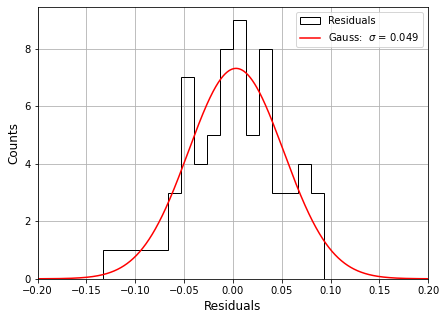

In [8]:
mu_fit , sigma_fit , A_fit = minuit_gauss.values

x_fit = np.linspace(xmin, xmax, 1000)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
ax.hist(residuals, bins=Nbins, range=(xmin,xmax), color='k', histtype='step', label='Residuals')
ax.plot(x_fit, gauss(x_fit, mu_fit, sigma_fit, A_fit), color='r', label=f'Gauss:  $\sigma$ = {sigma_fit:.3f}')
ax.set_xlabel('Residuals', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
ax.set(xlim=(xmin, xmax))
ax.legend(fontsize=10) , ax.grid()

In [9]:
sigma_fit



0.04869383791760361

# What to do next?

The reason for the (empty) plot below is, that though your data (hopefully) lies on a line, you're not able to see any smaller effects. However, if you plot the __residuals__ (the difference between your measurements and a fit to them), then you will much better be able to tell, if the data looks good. Also, it is from a historgram of the residuals, that you can determine, if your errors are Gaussian (or have any obvious outliers), and from the Standard Deviation what your (typical) uncertainty is.